# Adaptive - Ijsselmeer

Author: Luciano Raso, Delft University of Technology, Delft, The Netherlands. Section of Policy Analysis  
email: l.raso@tudelft.nl

In [1]:
cd ..

/Users/lraso/Documents/working directories/Monitoring_for_DAPP/Experiments


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import ast
from pathways.pathways import get_policy_def, find_pathway
from ema_workbench import load_results
import collections

plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Load data

In [3]:
# load data from EMA
results_df = pd.read_csv('data/Ijsselmeer/2018_11_05_results.csv',index_col=0)
len(results_df)
results_df.head()

4704

,low_flow_shift,peak_inflow_multiplier,sea_level_shift,pump_capacity,sluices_widening,summer_target,scenario_id,policy,model,demand deficit relative,dike failure frequency
0,0.0,1.0,0.000000,0,1,-0.2,0,"{'sluices_widening': 1, 'summer_target': -0.2,...",Ijsselmeer,0.014309,3956.322203
1,0.0,1.0,0.090909,0,1,-0.2,1,"{'sluices_widening': 1, 'summer_target': -0.2,...",Ijsselmeer,0.014309,3514.691410
2,0.0,1.0,0.181818,0,1,-0.2,2,"{'sluices_widening': 1, 'summer_target': -0.2,...",Ijsselmeer,0.014309,3035.269835
3,0.0,1.0,0.272727,0,1,-0.2,3,"{'sluices_widening': 1, 'summer_target': -0.2,...",Ijsselmeer,0.014309,2440.452948
4,0.0,1.0,0.363636,0,1,-0.2,4,"{'sluices_widening': 1, 'summer_target': -0.2,...",Ijsselmeer,0.014309,1890.216241


In [4]:
results_df[results_df['low_flow_shift']==0][results_df['peak_inflow_multiplier']==1][results_df['sea_level_shift']==0]

/Users/lraso/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,low_flow_shift,peak_inflow_multiplier,sea_level_shift,pump_capacity,sluices_widening,summer_target,scenario_id,policy,model,demand deficit relative,dike failure frequency
0,0.0,1.0,0.0,0,1,-0.2,0,"{'sluices_widening': 1, 'summer_target': -0.2,...",Ijsselmeer,0.014309,3956.322203
588,0.0,1.0,0.0,0,1,0.2,0,"{'sluices_widening': 1, 'summer_target': 0.2, ...",Ijsselmeer,0.008045,4066.363045
1176,0.0,1.0,0.0,0,2,-0.2,0,"{'sluices_widening': 2, 'summer_target': -0.2,...",Ijsselmeer,0.014309,4415.790868
1764,0.0,1.0,0.0,0,2,0.2,0,"{'sluices_widening': 2, 'summer_target': 0.2, ...",Ijsselmeer,0.008045,4002.882075
2352,0.0,1.0,0.0,500,1,-0.2,0,"{'sluices_widening': 1, 'summer_target': -0.2,...",Ijsselmeer,0.014309,4628.772450
2940,0.0,1.0,0.0,500,1,0.2,0,"{'sluices_widening': 1, 'summer_target': 0.2, ...",Ijsselmeer,0.008045,3922.183872
3528,0.0,1.0,0.0,500,2,-0.2,0,"{'sluices_widening': 2, 'summer_target': -0.2,...",Ijsselmeer,0.014309,5025.883299
4116,0.0,1.0,0.0,500,2,0.2,0,"{'sluices_widening': 2, 'summer_target': 0.2, ...",Ijsselmeer,0.008045,3499.685028


### Specify policy dimensions

In [5]:
actions_name = ['pump_capacity','sluices_widening','summer_target']
critical_uncertainties = ['low_flow_shift', 'peak_inflow_multiplier', 'sea_level_shift']
objectives = ['dike failure frequency','demand deficit relative']

In [6]:
color_list = ['clMaroon','clNavy','clOlive','clGreen','clPurple','clOrange','clYellow']
actions = []
for i, action_name in enumerate(actions_name):
    actions.append({'name':action_name, 
                    'caption': action_name, 
                    'color': color_list[i],
                    'predecessor':'current_situation'}) 

decreasing_actions = []#['winter_target'] # list actions whose effectiveness increase with decreasing of action value, default increasing
for action in actions:
    direction = -1 if action in decreasing_actions else 1
    action['values'] = np.sort(results_df[action['name']].unique())[::direction].tolist()

### 2-action Pathways 

We consider only pathways made of two actions (because the Deltares Pathway Generator does not include pathways made of more than two actions)

In [7]:
pathways = []
for i, action in enumerate(actions):
    left_actions = actions[i+1:]
    for combined_action in left_actions:
        pathway = {'name': action['name'],
                   'caption': action['name'] + ' + ' + combined_action['name'],
                   'combined_to': combined_action['name'],
                   'predecessor': action['name'],
                   'color': action['color'], 
                   'values': [action['values'][-1]]}
        pathways.append(pathway)

In [8]:
# var new_var correspondence
name_crit_unc ={'low_flow_shift':'low flow reduction $[m^3/s]$',
      'peak_inflow_multiplier': 'max discharge increase $[\%]$ ',
      'sea_level_shift': 'sea level rise $[m]$',
      'wind_multiplier' : 'change wind speed, $[\%]$ '}
     # 'winter_target': 'winter target level $[mNAP]$',}
    
    

In [9]:
# rename
old_var_name = results_df.columns.copy(deep=True)
new_var_name = [ name_crit_unc[var] if var in name_crit_unc else var for var in old_var_name  ]
# results_df.columns = new_var_name

### define scenarios data

In [10]:
scenarios_df = results_df.iloc[results_df['scenario_id'].unique(),0:len(critical_uncertainties)]
scenarios_df.shape

(588, 3)

### Define policy success

In [11]:
policy_success_threshold = {}
policy_success_threshold['dike failure frequency'] = 2500
policy_success_threshold['demand deficit relative'] = 0.015 # in *100 %

sign = {} # negative is the objective to be minimized, positive if to be maximized 
sign['dike failure frequency'] = -1
sign['demand deficit relative'] = +1

### Identify policy success scenarios

In [12]:
policy_success = pd.DataFrame(results_df[['policy','scenario_id']])
for objective in objectives:
    policy_success[objective] = sign[objective] * results_df[objective] <= sign [objective] * policy_success_threshold[objective]

#### overall success of policy success is if all criteria are satisfied 

In [13]:
policy_success['overall']= policy_success[objectives].all(axis=1)

#### Pivot policy-success results in scenarios (rows) vs policy (columns) table

In [97]:
success_per_policy = policy_success.pivot(columns='policy', values='overall', index='scenario_id')   
policies = success_per_policy.columns
success_per_policy.sum()

policy
{'sluices_widening': 1, 'summer_target': -0.2, 'pump_capacity': 0}       51
{'sluices_widening': 1, 'summer_target': -0.2, 'pump_capacity': 500}    318
{'sluices_widening': 1, 'summer_target': 0.2, 'pump_capacity': 0}       141
{'sluices_widening': 1, 'summer_target': 0.2, 'pump_capacity': 500}     453
{'sluices_widening': 2, 'summer_target': -0.2, 'pump_capacity': 0}      243
{'sluices_widening': 2, 'summer_target': -0.2, 'pump_capacity': 500}    311
{'sluices_widening': 2, 'summer_target': 0.2, 'pump_capacity': 0}       375
{'sluices_widening': 2, 'summer_target': 0.2, 'pump_capacity': 500}     450
dtype: int64

## Include observational uncertainty

0.08673469387755102

### Observational uncertainty Signposts

In [15]:
forcings = pd.read_csv('data/Ijsselmeer/forcings.csv',index_col=0,parse_dates=[0])

In [16]:
window_size = 10 # window size of ten years

### Signpost $S_{sea}$

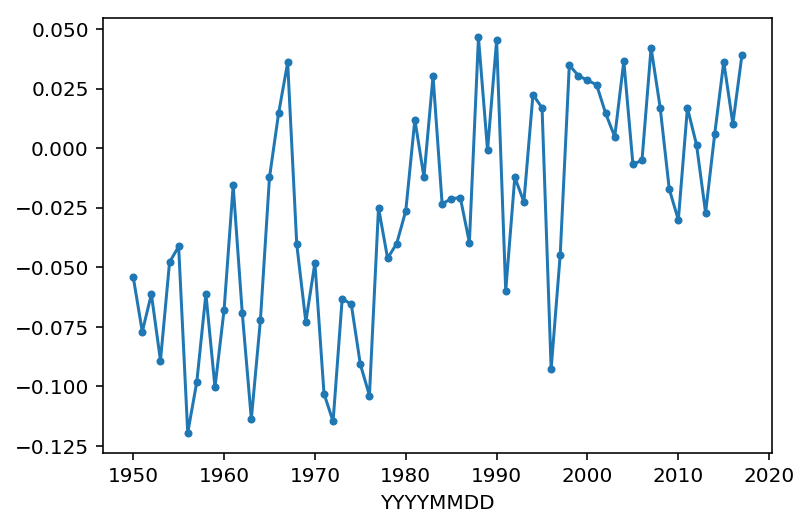

In [17]:
yearly_wl_mean = forcings['sea level'].groupby(forcings.index.year).mean()
yearly_wl_mean.plot(marker='.')

In [18]:
sigma_Ssea = yearly_wl_mean.std() / np.sqrt( window_size )
sigma_Ssea

0.014741009287527185

### Signpost $S_{qmax}$

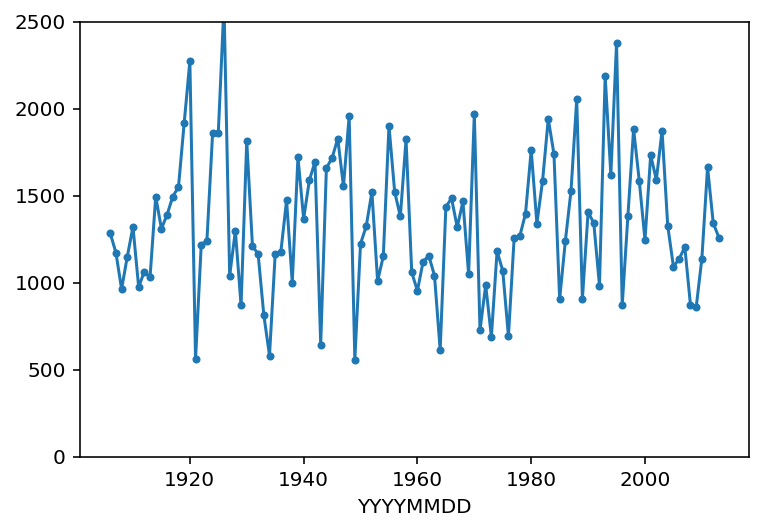

In [19]:
yearly_q_max = forcings['inflow ijssel'].groupby(forcings.index.year).max()
yearly_q_max.plot(marker='.',ylim=[0,2500])

In [20]:
mu_Sqmax = yearly_q_max.mean()
sigma_Sqmax = yearly_q_max.std() / np.sqrt( window_size )
mu_Sqmax, sigma_Sqmax

(1346.1981481481478, 128.7893272107288)

### Signpost $S_{qmin}$

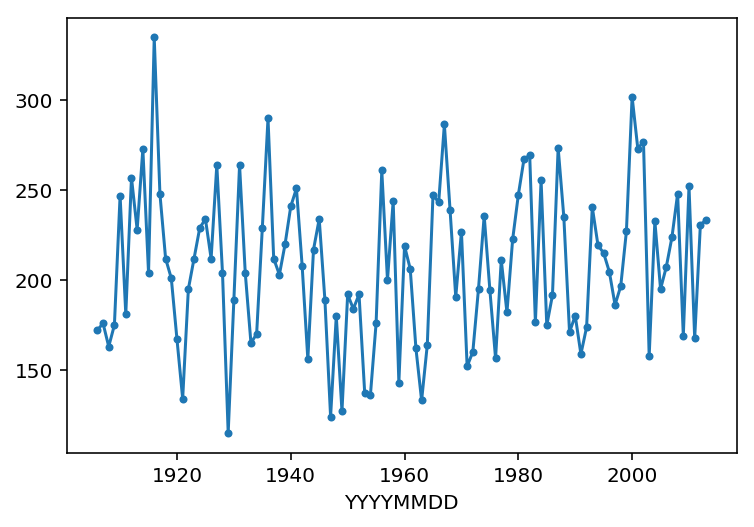

In [21]:
yearly_q_min = forcings['inflow ijssel'].groupby(forcings.index.year).min()
yearly_q_min.plot(marker='.')

In [22]:
mu_Sqmin = yearly_q_min.mean()
sigma_Sqmin = yearly_q_min.std() / np.sqrt( window_size )
mu_Sqmin, sigma_Sqmin

(207.75740740740736, 13.504195404657475)

## Include Observational Uncertainty

In [23]:
N_sampling = 30

In [24]:
obs_unc = {'S_sea':{'uncertainty':'sea_level_shift','sigma':sigma_Ssea},
           'S_qmax':{'uncertainty':'peak_inflow_multiplier','mult_factor':mu_Sqmax,'sigma':sigma_Sqmax},
           'S_qmin':{'uncertainty':'low_flow_shift','mult_factor':-1,'mu':mu_Sqmin,'sigma':sigma_Sqmin}}

In [25]:
scenarios_indicators = pd.concat([scenarios_df]*(N_sampling*len(obs_unc)))
success_per_policy_indicators = pd.concat([success_per_policy]*(N_sampling*len(obs_unc)))
size_df = len(scenarios_indicators)

In [26]:
for signpost in obs_unc:
    mult_factor = obs_unc[signpost]['mult_factor'] if 'mult_factor' in obs_unc[signpost] else 1
    mu = obs_unc[signpost]['mu'] if 'mu' in obs_unc[signpost] else 0
    scenarios_indicators[signpost] = mult_factor * scenarios_indicators[obs_unc[signpost]['uncertainty']] + np.random.normal(mu,obs_unc[signpost]['sigma'],size_df)

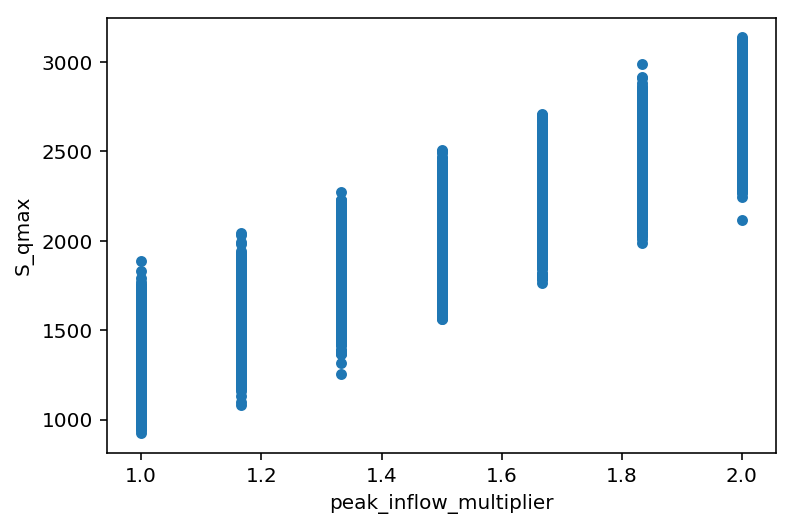

In [27]:
scenarios_indicators.plot(kind='scatter',x='peak_inflow_multiplier',y='S_qmax')

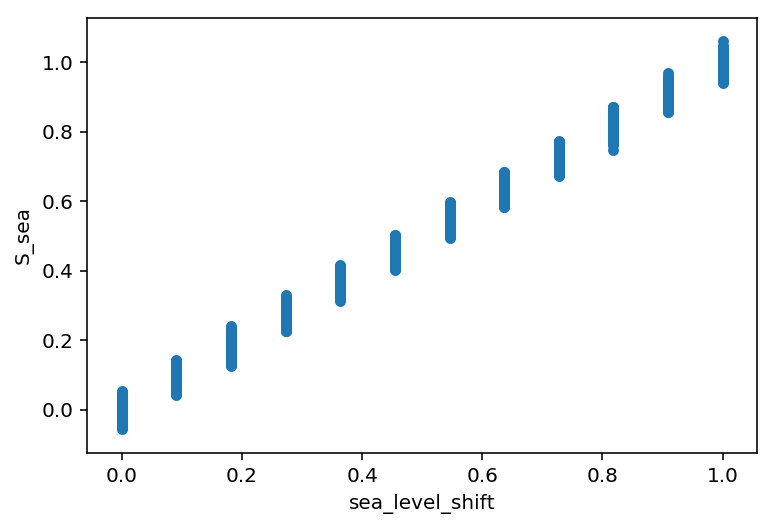

In [28]:
scenarios_indicators.plot(kind='scatter',x='sea_level_shift',y='S_sea')

In [29]:
signposts = [signpost for signpost in obs_unc]
signposts

['S_sea', 'S_qmax', 'S_qmin']

## Identify Adaptation Tipping Points by scenario discovery

### Find ATP on the space of critical uncertainties 

We consider two criteria
* Parsimony
* Fixed level of risk


The parsimonious approach identify a monitoring system made of one signpost for each action, selecting the signpost that better identify policy success, and select the trigger value that maximize density (min risk). 

The fixed level of risk approach selects one or more the signposts that offer a level of density not smaller than 90%, equivalent to a risk of missing the adaptation signal with 10% of chance.     

#### Use of Range Search (PRIM)

In [30]:
from ema_workbench.analysis import prim

In [ ]:
signpost_based_monitor = False
observables = signposts if signpost_based_monitor else critical_uncertainties

In [99]:
boxes = {}

cols = ['UpperBound','LowerBound','RelativeATP','Density','Coverage']
ATP_parsimony = pd.DataFrame(index=policies, columns=cols)
ATP_risk_averse = pd.DataFrame(index=policies, columns=cols)

lower_lim = 0
upper_lim = 1 # select the second value (i.e. the max value) in the box, because the signposts are all activated by larger values

if signpost_based_monitor:
    lower_bound = np.array([58.0,817.8327073939638, -0.049]) #mu_Sqmin - 100 - 3 * sigma_Sqmin, mu_Sqmax - 3 * sigma_Sqmax ,0.0 - 3 * sigma_Ssea])
    upper_bound = np.array([254.70, 3208., 1.05])  #[mu_Sqmin - 3 * sigma_Sqmin, 2 * mu_Sqmax + 3 * sigma_Sqmax,1.0 + 3* sigma_Ssea])
else:
    lower_bound = np.array([0.,1.,0.])
    upper_bound = np.array([100.,2.,1.])

 

with open('ATP.txt','w') as file:
    for policy in policies:
        x = scenarios_indicators[observables].to_records(index=False)
        y = success_per_policy_indicators[policy].values
        prim_alg = prim.Prim(x, y, threshold=0.05,peel_alpha=0.025,paste_alpha=0.025,mass_min=0.025)
        box = prim_alg.find_box()
        box.peeling_trajectory['risk missed adaptation'] = (1 - box.peeling_trajectory['density']) * (box.peeling_trajectory['mass'] / box.peeling_trajectory['mean'])
        box.peeling_trajectory['risk regretful action'] = 1 - box.peeling_trajectory['coverage']
        boxes[policy] = box
      
        file.write(policy +'\n')
        file.write(box.peeling_trajectory.to_string()+'\n')    

/Users/lraso/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


67

14553

[1.55683389e-03 9.24841703e-01 1.89164551e+02]


ValueError: min() arg is an empty sequence

In [ ]:
# criteria 
citerium = {}
citerium['parsimony'] = 
criterium['risk'] = 
         
for policy in policies:        # criteria : single sigpost with the largest density
        i = max(box.peeling_trajectory.index[box.peeling_trajectory['res dim'] == 1])
        upper_bound_box_rec = box.box_lims[i][:][upper_lim]
        upper_bound_box = np.array([val.astype(float) for val in upper_bound_box_rec])
        ATP_parsimony['UpperBound'].loc[policy] = upper_bound_box
        
        lower_bound_box_rec = box.box_lims[i][:][lower_lim]
        lower_bound_box = np.array([val.astype(float) for val in lower_bound_box_rec])
        ATP_parsimony['LowerBound'].loc[policy] = lower_bound_box
        
        print( (upper_bound_box - lower_bound_box) / (upper_bound - lower_bound)) 
        
        ATP_parsimony['RelativeATP'].loc[policy] = np.mean( (upper_bound_box - lower_bound_box ) / (upper_bound - lower_bound) ) #/  (upper_bound - lower_bound) )
        ATP_parsimony['Density'].loc[policy] = box.peeling_trajectory.density[i]
        ATP_parsimony['Coverage'].loc[policy] = box.peeling_trajectory.coverage[i]

        
        # criteria : density not smaller than threshold %
        if signpost_based_monitor:
            th = density['uncertainties'][policy]
        else:
            th = 0.75
        
        i = min(box.peeling_trajectory.index[box.peeling_trajectory['density'] > th])
        upper_bound_box_rec = box.box_lims[i][:][upper_lim]
        upper_bound_box = np.array([val.astype(float) for val in upper_bound_box_rec])
        ATP_risk_averse['UpperBound'].loc[policy] = upper_bound_box
        
        lower_bound_box_rec = box.box_lims[i][:][lower_lim]
        lower_bound_box = np.array([val.astype(float) for val in lower_bound_box_rec])
        ATP_risk_averse['LowerBound'].loc[policy] = lower_bound_box

        ATP_risk_averse['RelativeATP'].loc[policy] = np.mean( (upper_bound_box - lower_bound_box) /  (upper_bound - lower_bound) )
        ATP_risk_averse['Density'].loc[policy] = box.peeling_trajectory.density[i]
        ATP_risk_averse['Coverage'].loc[policy] = box.peeling_trajectory.coverage[i]

In [ ]:
lower_bound,upper_bound

In [82]:
ATP_parsimony

,UpperBound,LowerBound,RelativeATP,Density,Coverage
policy,,,,,
"{'sluices_widening': 1, 'summer_target': -0.2, 'pump_capacity': 0}","[100.0, 1.9166666666666665, 1.0]","[0.0, 1.0, 0.0]",0.972222,0.10119,1
"{'sluices_widening': 1, 'summer_target': -0.2, 'pump_capacity': 500}","[100.0, 2.0, 0.7727272727272727]","[0.0, 1.0, 0.0]",0.924242,0.714286,0.990566
"{'sluices_widening': 1, 'summer_target': 0.2, 'pump_capacity': 0}","[100.0, 2.0, 0.2272727272727273]","[0.0, 1.0, 0.0]",0.742424,0.802721,0.836879
"{'sluices_widening': 1, 'summer_target': 0.2, 'pump_capacity': 500}","[100.0, 2.0, 0.9545454545454546]","[0.0, 1.0, 0.0]",0.984848,0.829314,0.986755
"{'sluices_widening': 2, 'summer_target': -0.2, 'pump_capacity': 0}","[100.0, 2.0, 0.5909090909090908]","[0.0, 1.0, 0.0]",0.863636,0.708455,1
"{'sluices_widening': 2, 'summer_target': -0.2, 'pump_capacity': 500}","[100.0, 2.0, 0.7727272727272727]","[0.0, 1.0, 0.0]",0.924242,0.698413,0.990354
"{'sluices_widening': 2, 'summer_target': 0.2, 'pump_capacity': 0}","[100.0, 2.0, 0.7727272727272727]","[0.0, 1.0, 0.0]",0.924242,0.84127,0.989333
"{'sluices_widening': 2, 'summer_target': 0.2, 'pump_capacity': 500}","[100.0, 2.0, 0.9545454545454546]","[0.0, 1.0, 0.0]",0.984848,0.821892,0.984444


In [ ]:
ATP_risk_averse

#### ZOOM IN: tradeoff density-coverage

In [76]:
coverage = {}
density = {}

In [84]:
if signpost_based_monitor:
    coverage['signposts'] = ATP_risk_averse['Coverage']
    density['signposts'] = ATP_risk_averse['Density']
else: 
    coverage['uncertainties'] = ATP_risk_averse['Coverage']
    density['uncertainties'] = ATP_risk_averse['Density']

In [89]:
density['uncertainties'][policy]

0.9285714285714286

In [87]:
coverage['diff'] = coverage['uncertainties'] - coverage['signposts']
density['diff'] = density['uncertainties'] - coverage['signposts']

In [88]:
coverage['diff'], density['diff']

(policy
 {'sluices_widening': 1, 'summer_target': -0.2, 'pump_capacity': 0}       0.0568627
 {'sluices_widening': 1, 'summer_target': -0.2, 'pump_capacity': 500}    -0.0382949
 {'sluices_widening': 1, 'summer_target': 0.2, 'pump_capacity': 0}        0.0267928
 {'sluices_widening': 1, 'summer_target': 0.2, 'pump_capacity': 500}     -0.0212656
 {'sluices_widening': 2, 'summer_target': -0.2, 'pump_capacity': 0}     -0.00635574
 {'sluices_widening': 2, 'summer_target': -0.2, 'pump_capacity': 500}    -0.0391568
 {'sluices_widening': 2, 'summer_target': 0.2, 'pump_capacity': 0}       0.00533333
 {'sluices_widening': 2, 'summer_target': 0.2, 'pump_capacity': 500}    -0.00797531
 Name: Coverage, dtype: object, policy
 {'sluices_widening': 1, 'summer_target': -0.2, 'pump_capacity': 0}        0.586275
 {'sluices_widening': 1, 'summer_target': -0.2, 'pump_capacity': 500}      0.077361
 {'sluices_widening': 1, 'summer_target': 0.2, 'pump_capacity': 0}         0.260227
 {'sluices_widening': 1, 'sum

In [95]:
b = boxes["{'sluices_widening': 1, 'summer_target': -0.2, 'pump_capacity': 0}"]
b1 = boxes["{'sluices_widening': 2, 'summer_target': 0.2, 'pump_capacity': 500}"]

KeyError: "{'sluices_widening': 2, 'summer_target': 0.2, 'pump_capacity': 500}"

In [96]:
boxes

{"{'sluices_widening': 1, 'summer_target': -0.2, 'pump_capacity': 0}": <ema_workbench.analysis.prim.PrimBox at 0x123c4e320>}

In [39]:
b.peeling_trajectory.head(15)

,coverage,density,mass,mean,res dim
0,1.0,0.086735,1.000000,0.086735,0
1,1.0,0.088959,0.975000,0.088959,1
2,1.0,0.091240,0.950624,0.091240,1
3,1.0,0.093580,0.926852,0.093580,1
4,1.0,0.095981,0.903666,0.095981,1
5,1.0,0.098443,0.881066,0.098443,1
6,1.0,0.100968,0.859033,0.100968,1
7,1.0,0.103558,0.837547,0.103558,1
8,1.0,0.106216,0.816591,0.106216,1
9,1.0,0.108941,0.796164,0.108941,1


In [40]:
b.box_lims[0:10]

[array([(-0.05657164,  926.82557656,  48.78327787),
        ( 1.06098529, 3137.35196561, 256.67511951)],
       dtype=(numpy.record, [('S_sea', '<f8'), ('S_qmax', '<f8'), ('S_qmin', '<f8')])),
 array([(-0.05657164,  926.82557656,  48.78327787),
        ( 1.00696706, 3137.35196561, 256.67511951)],
       dtype=(numpy.record, [('S_sea', '<f8'), ('S_qmax', '<f8'), ('S_qmin', '<f8')])),
 array([(-0.05657164,  926.82557656,  48.78327787),
        ( 0.99644326, 3137.35196561, 256.67511951)],
       dtype=(numpy.record, [('S_sea', '<f8'), ('S_qmax', '<f8'), ('S_qmin', '<f8')])),
 array([(-0.05657164,  926.82557656,  48.78327787),
        ( 0.9827051 , 3137.35196561, 256.67511951)],
       dtype=(numpy.record, [('S_sea', '<f8'), ('S_qmax', '<f8'), ('S_qmin', '<f8')])),
 array([(-0.05657164,  926.82557656,  48.78327787),
        ( 0.92405381, 3137.35196561, 256.67511951)],
       dtype=(numpy.record, [('S_sea', '<f8'), ('S_qmax', '<f8'), ('S_qmin', '<f8')])),
 array([(-0.05657164,  926.82557656

In [41]:
box.box_lims[i][:][lower_lim]

(-0.05657164, 1419.38441661, 48.78327787)

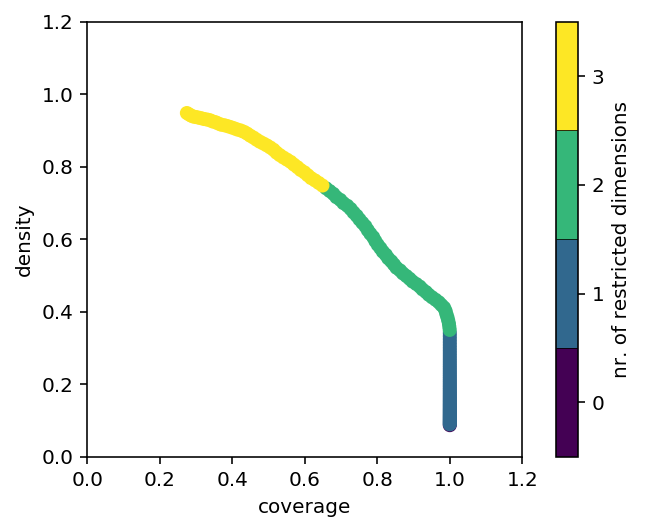

In [42]:
p1 = b.show_tradeoff()

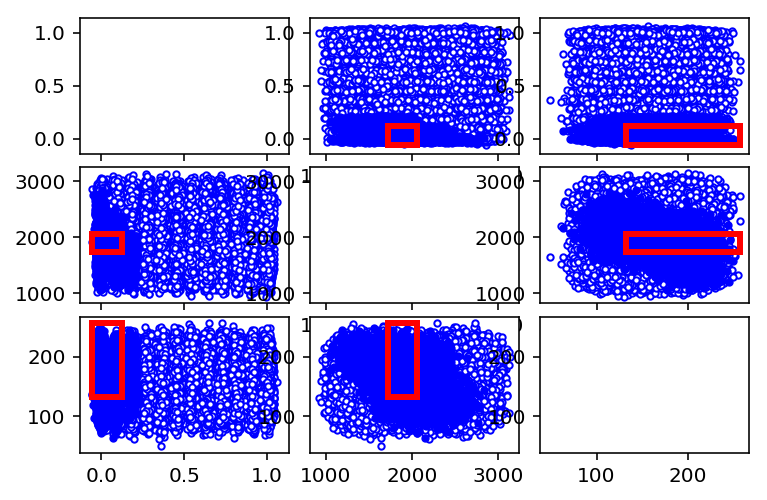

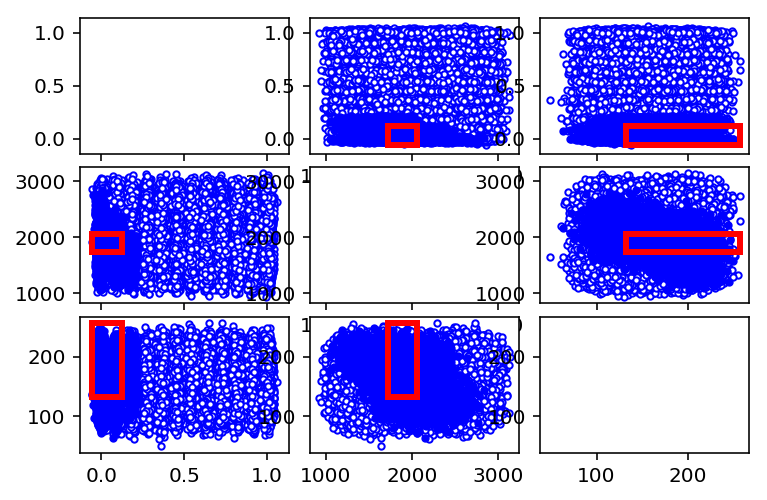

In [43]:
b.show_pairs_scatter()

In [44]:
b1.show_tradeoff()
plt.show()

NameError: name 'b1' is not defined

In [ ]:
#b1.peeling_trajectory
#f = (b.peeling_trajectory.coverage + b.peeling_trajectory.density)/2

In [ ]:
b1.show_pairs_scatter()

In [ ]:
b.inspect(int(f.idxmax()))

In [ ]:
b

In [ ]:
b.inspect(int(f.idxmax()),style='graph')

In [ ]:
b.inspect(11,style='graph')

In [ ]:
box_id=None
box_res = b.inspect(4)
box_res2 = b.inspect(box_id,style='graph')


### Rendering adaptation pathways
#### Creating xml to be loaded within the [Pathways Generator](https://publicwiki.deltares.nl/display/AP/Pathways+Generator) by [Deltares](www.deltares/nl)

In [ ]:
from pathways.pathways import create_patwhays_map

In [ ]:
# find correspondence policy as in table to dictionary of actions
correspondence_table = get_policy_def(results_df,actions_name)

In [ ]:
# auxiliary functions 
def find_policy_id(policy_dict,correspondence_table):
    for policy_id in correspondence_table:
        if correspondence_table[policy_id]==policy_dict:
            return(policy_id)

def find_policy(elements,precedent_policy,correspondence_table):
    
    for action in elements:
        print (action)
        
        new_policy = precedent_policy.copy()
        
        if 'values' in action: # not current situation
            new_policy[action['name']]=action['values'][-1]

        if 'combined_to' in action: # is a pathway
            value_combined = [combined_action['values'][-1] for combined_action in elements if combined_action['name']==action['combined_to']][0]
            new_policy[action['combined_to']] = value_combined
            
        new_policy_id = find_policy_id(new_policy,correspondence_table)
        action['policy_id'] = new_policy_id
        
        

In [ ]:
# add action for current situation

current_situation = {}
for action_name in actions_name:
    action_value = [action['values'][0] for action in actions if action['name']==action_name][0]
    current_situation[action_name] = action_value 

action_current_situation = {'caption':'current_situation', 'name': 'current_situation','color':'clGray','predecessor_id':'-1'}

#action_current_situation['policy_id'] = find_policy_id(current_situation,correspondence_table)
# add current action to list of actins
elements = [action_current_situation] + actions + pathways

In [ ]:
find_policy(elements,current_situation,correspondence_table)

#### select critical uncertainty to render

In [ ]:
# select critical uncertainty to render
rendered_uncertainty = 'peak_inflow_multiplier'#'sea_level_shift' # 
pos_rend_unc = critical_uncertainties.index(rendered_uncertainty)

In [ ]:
elements

In [ ]:
# assign tippingpoint value for the selected critical uncertainty
for action in elements:
    action['tippingpointvalue'] = ATP_risk_averse['RelativeATP'].loc[action['policy_id']]

In [ ]:
ATP_parsimony.loc[action['policy_id']]

In [ ]:
# check results
for el in elements:
    print(el['caption'])
    print(el['tippingpointvalue'])

##### Generate pathway file

In [ ]:
graph_settings = {'xaxistitle':'relative change','maxtippingpoint':1, 'fontsize': 20}
xml_str = create_patwhays_map(elements,graph_settings = graph_settings)

pathway_file = open('figures/Ijsselmeer/risk_averse_density90_ATP_08_Nov.pathways', 'w')
pathway_file.write(xml_str)
pathway_file.close()

In [ ]:
pathway

## Identify Adaptation Tipping Points, including observational uncertainty

### Find ATP on the space of observable variables

In [ ]:
obs_unc_low_flow = 10
obs_unc_peak_discharge = 100 
obs_unc_sea_level = 0.1



obs_unc_comatrix = np.matrix([obs_unc_low_flow,0,0],[0,obs_unc_peak_discharge,0],[0,0,obs_unc_sea_level])

In [ ]:
actions

In [ ]:
import graphviz 
from graphviz_tree import *

In [ ]:
test_new = False
if test_new == True:
    export_graphviz_func = export_graphviz_temp
else:
    export_graphviz_func = tree.export_graphviz

In [ ]:
policies_names = []
for policy in policy_success_ordinal.columns:
    policies_names.append(policy.replace(',','\n'))

In [ ]:
class_names = list(policy_success_ordered.columns)
class_names.append('None')
class_names = [policy_name.replace(',','\n') for policy_name in class_names ]

In [ ]:
pathways = export_graphviz_func(clf, out_file=None, #max_depth=4,
                                feature_names=scenarios_df.columns, 
                                class_names=class_names, 
                                filled=True,
                                label = 'all',
                                leaves_parallel =False,
                                #node_ids=True,
                                #rounded=True,
                                #impurity = True, 
                                #proportion = True,
                                rotate = True,
                                precision = 3
                                #,minimal_info=True
                               )  
pathways_rendered = graphviz.Source(pathways)
pathways_rendered

In [ ]:

cmap_name = 'my_list'
for n_bin, ax in zip(n_bins, axs.ravel()):
    # Create the colormap
    cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=n_bin)
    # Fewer bins will result in "coarser" colomap interpolation
    im = ax.imshow(Z, interpolation='nearest', origin='lower', cmap=cm)
    ax.set_title("N bins: %s" % n_bin)
    fig.colorbar(im)

In [ ]:
import pylab as pl
from matplotlib.colors import LinearSegmentedColormap


max_cost = 340 * 1.3
a = np.array([[0,max_cost]])
pl.figure(figsize=(3, 10))

colors = [(0, 0.7, 0),(0.7, 0, 0)]  # G -> R
n_bins = 30
color_map = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
img = pl.imshow(a, cmap=color_map)
pl.gca().set_visible(False)
cax = pl.axes([0, 1, 0.1, 1])
pl.colorbar(cax=cax)
plt.ylabel('Cost $[M- euro]$')
pl.savefig("colorbar.pdf")


In [ ]:
cost_policy = 100
color_for_policy = color_map(cost_policy/max_cost)[0:3]
color_for_policy

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
clf_iris = tree.DecisionTreeClassifier()
clf_iris.fit(iris.data, iris.target)


In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [ ]:
iris.target_names

In [ ]:
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

# Load data
from sklearn.datasets import load_iris


iris = load_iris()

plt.figure(figsize=(10,7))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = tree.DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        
plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc=0)
#plt.axis("tight")

In [ ]:
actions


In [ ]:
all_actions

### Exploratory data analysis

In [ ]:
# plot_area_success
pos = -1
print(policies[pos])
policy_under_analysis = pd.DataFrame(success_per_policy.iloc[:,pos].rename(columns={policies[pos]:'policy'}))
                                                              
scenarios_df_success = scenarios_df.join(policy_under_analysis)
    
sns.pairplot(scenarios_df_success,hue=0)
plt.title(policies[pos])

In [ ]:
policies

In [ ]:
var1 = 'sea_level_shift'
var2 = 'peak_inflow_multiplier'

policy = "{'winter_target': -0.4, 'sluices_widening': 1}"

#for policy in policies:
for policy in [policy]:
    
    scenarios_vs_success = scenarios_df.join(success_per_policy[policy].apply(int))
    pivoted_success = scenarios_vs_success.pivot_table(index=var1,columns=var2,values=policy,aggfunc=np.sum) 
    pivoted_total = scenarios_vs_success.pivot_table(index=var1,columns=var2,values=policy,aggfunc='count')
    frequency_success = pivoted_success / pivoted_total
    # plotting
    x,y = frequency_success.index, frequency_success.columns
    X,Y = np.meshgrid(x,y)
    levelsf=[0.2,1]
    levels=[0.2,0.5,0.8]
    linestyles = ['dotted','solid','dotted']
    #plt1 = plt.contourf(X, Y, frequency_success.values,levelsf,label=policy,colors=policy_color[policy],linestyles = linestyles, linewidth = 5 ,alpha=0.4)#, cmap=plt.cm.jet);
    plt2 = plt.contour(X, Y, frequency_success.values,levels,label=policy,colors=policy_color[policy],linestyles = linestyles, linewidth = 5 )#, cmap=plt.cm.jet);
    
plt.xlabel(var1)
plt.ylabel(var2)


In [ ]:
scenarios_df.head()

In [ ]:
scenarios_df,success_per_policy.head()